In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import torch
import pickle
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

np.random.seed(0)
gen = torch.Generator().manual_seed(0)

# Task 3: ISTA for Sparse Vector Recovery



## Section 1: Optimization


Consider the following example where $\mathbf{z} \in \mathbb{R}^{100}$,  $\mathbf{A} \in \mathbb{R}^{100 \times 100}$ and $\mathbf{n} \sim \mathcal{N}(0, 0.05^{2}\mathbf{I}) \in \mathbb{R}^{100}$:

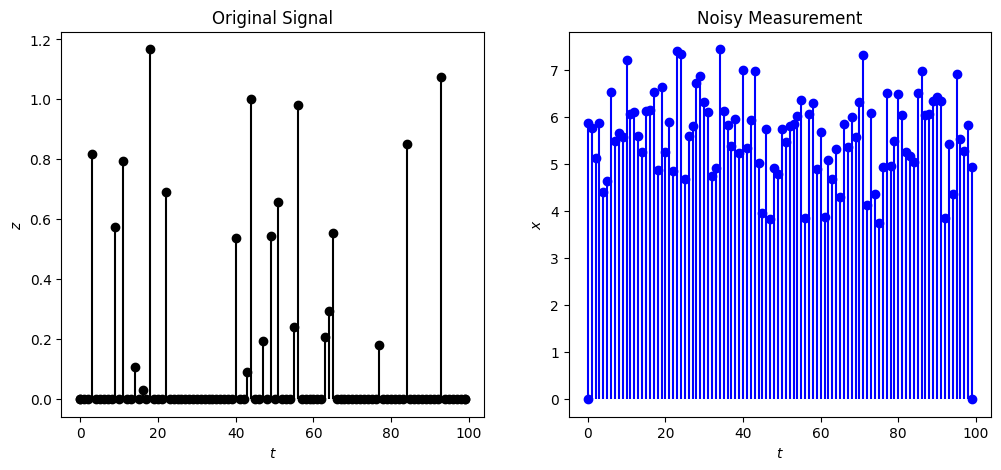

In [3]:
t = np.arange(0, 100, 1)
z = 1.5 * np.random.rand(len(t))
z = z * np.array([0 if np.random.rand() < 0.8 else 1 for i in range(len(t))])

A = np.random.rand(100, 100)

sigma = 0.05
noise = np.random.normal(0, sigma)
x = A @ z + noise


fig = plt.figure(1, dpi=100, figsize=(12, 5))
ax  = fig.subplots(nrows=1, ncols=2)
_   = ax[0].stem(t, z, "k", basefmt="ko")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, x, "b", basefmt="bo")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$x$')
_   = ax[1].set_title("Noisy Measurement")

### Task 3.1:

Implement the ISTA class for a fixed number of iterations. For the given signal, plot the total loss and sparse loss as a function of iterations. Also plot the recovered and original signals on a $2 \times 1$ grid.

In [4]:
class ISTA:
    def __init__(self, lambd: float, max_iter=1000):
        """Initialize the ISTA algorithm parameters."""
        self.lambd = lambd
        self.max_iter = max_iter
        self.loss_history_reconstruction = []
        self.loss_history_sparse = []
        self.loss_history_combined = []

    def _soft(self, z: np.ndarray, T: float) -> np.ndarray:
        """Apply soft-thresholding to the input vector."""
        return np.sign(z) * np.maximum(np.abs(z) - T, 0)

    def _run_one_iter(self, z: np.ndarray, x: np.ndarray, A: np.ndarray, alpha: float):
        """Run one iteration of the ISTA algorithm."""
        # Compute the gradient of the least squares term
        gradient = A.T @ (x - A @ z)
        
        # Update z based on the soft-thresholding step
        z_next = self._soft(z + (1 / alpha) * gradient, self.lambd / (2 * alpha))

        # Calculate losses for tracking purposes
        reconstruction_loss = np.linalg.norm(x - A @ z_next, 2)**2
        sparse_loss = self.lambd * np.linalg.norm(z_next, 1)
        combined_loss = reconstruction_loss + sparse_loss

        # Store losses in history
        self.loss_history_reconstruction.append(reconstruction_loss)
        self.loss_history_sparse.append(sparse_loss)
        self.loss_history_combined.append(combined_loss)

        return z_next

    def optimize(self, A: np.ndarray, x: np.ndarray, alpha: float) -> np.ndarray:
        """Optimize the solution using the ISTA algorithm."""
        # Initialize z to be a zero vector
        z = np.zeros(A.shape[1])

        # Iterate for the set number of iterations
        for _ in range(self.max_iter):
            z = self._run_one_iter(z, x, A, alpha)

        return z

    def visualize_loss_history(self):
        """Visualize the loss history over the iterations."""
        plt.figure(figsize=(12, 8))
        plt.plot(self.loss_history_reconstruction, label="Reconstruction Loss (||x - Az||^2_2)")
        plt.plot(self.loss_history_sparse, label="Sparse Loss (λ||z||_1)")
        plt.plot(self.loss_history_combined, label="Combined Loss (||x - Az||^2_2 + λ||z||_1)")
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss History Over Iterations')
        plt.grid(True)
        plt.show()


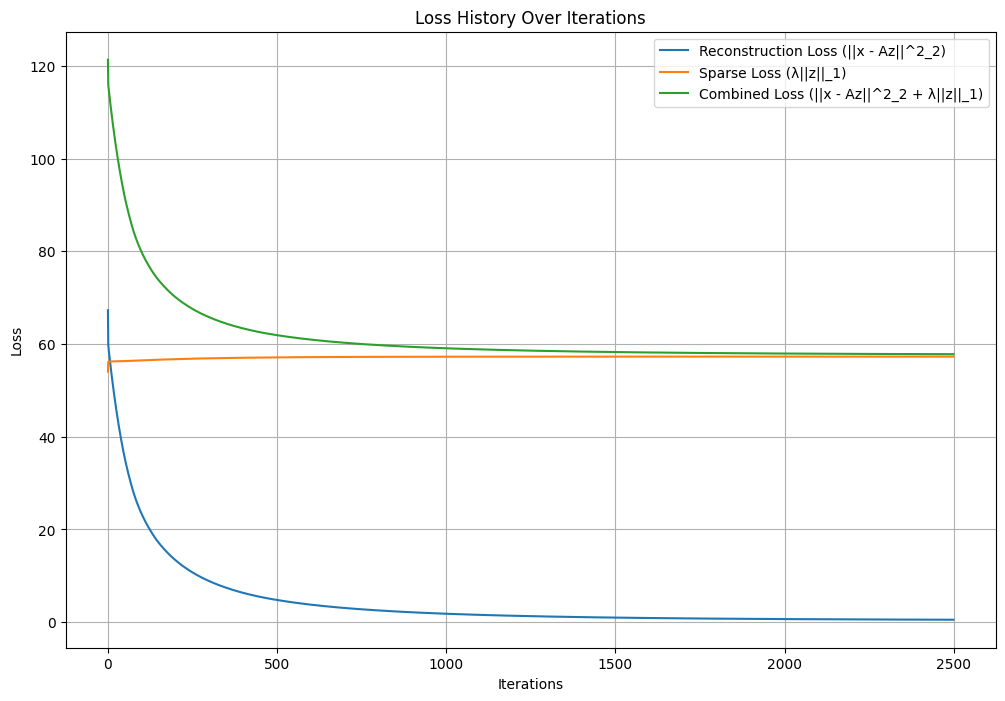

In [5]:
opt = ISTA(5, max_iter=2500)
eigs, _ = np.linalg.eig(A.T @ A)
alpha = max(eigs) + 100
z_recovered = opt.optimize(A, x, alpha)
opt.visualize_loss_history()

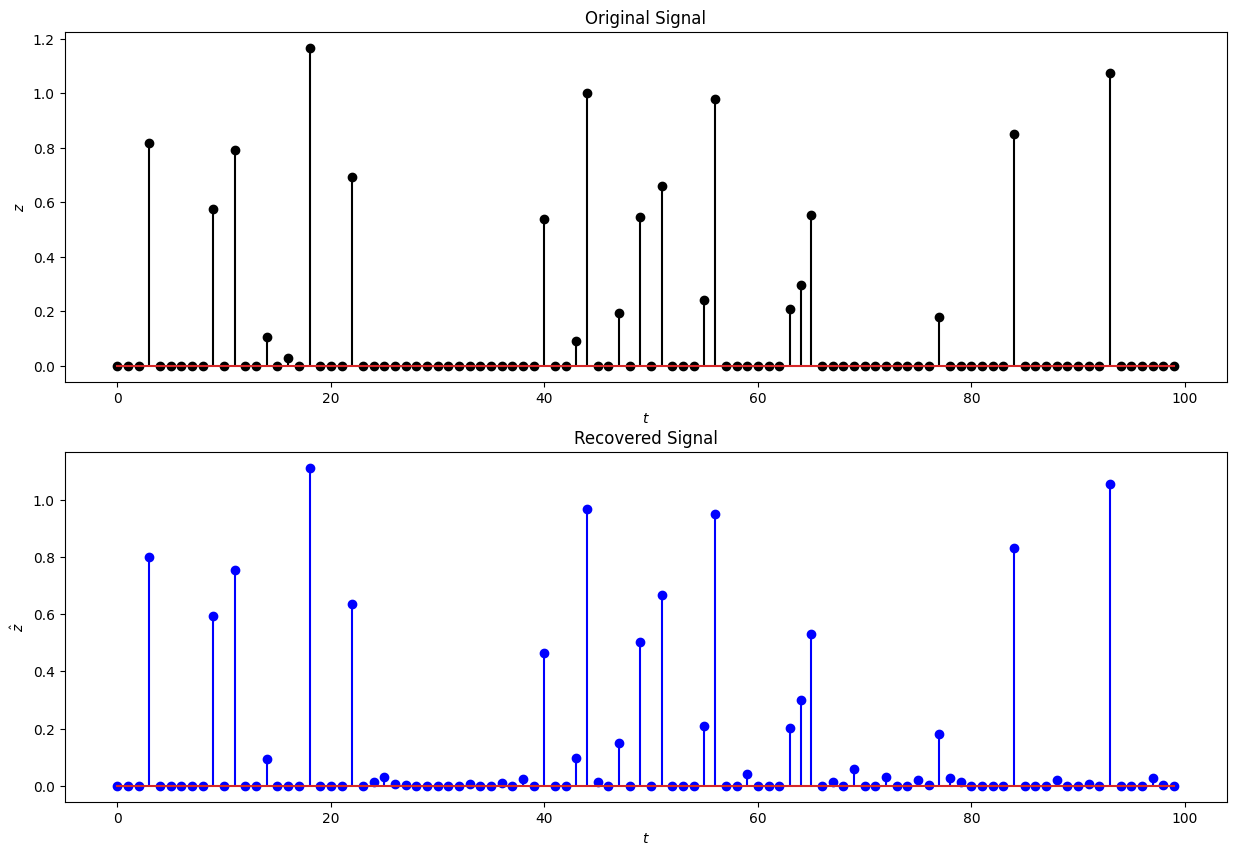

In [5]:
fig = plt.figure(dpi=100, figsize=(15, 10))
ax  = fig.subplots(2, 1)
_   = ax[0].stem(t, z, "k", label="Original Signal")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, z_recovered, "b", label="Recovered Signal")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$\hat{z}$')
_   = ax[1].set_title("Recovered Signal") 

### Task 3.2

Add in your response to Task 3.2 from the manual in the cells below. -- 

#### Answered in report

## Section 2: Unfolding

In section 1, we had the luxury of knowing what our measurement matrix $A$ was. Yet, we had to choose values of $\alpha$ and $\lambda$ manually and a little experimentation will show you that their choice impacts the performance of the algorithm greatly. Our new problem setup assumes that we only have access to some noisy measurements $\mathbf{z}$ and our objective is to recover the underlying sparse signal $\mathbf{z}$ with no knowledge of $\mathbf{A}$.

To do so, we turn our attention towards neural networks.


The following code will help you load and create a dataset from the given `sparse_signals.pkl` file. Do not change it.

The training data comprises of 9000 input $\mathbf{z} \in \mathbb{R}^{100}$ and output $\mathbf{x} \in \mathbb{R}^{100}$ signal pairs while test set contains 1000 samples.

In [6]:
class SparseSignalsDataset(Dataset):
  def __init__(self, Z, X):
    self.z = torch.tensor(np.array(Z), dtype=torch.float32)
    self.x = torch.tensor(np.array(X), dtype=torch.float32)

  def __len__(self):
    return len(self.z)

  def __getitem__(self, idx):
    return self.z[idx], self.x[idx]

In [7]:
def load_file(filename='signals.pkl'):
    with open(filename, 'rb') as f:
        Z, X = pickle.load(f)
    return Z, X

In [8]:
# DO NOT MODIFY
filename = "/Users/haseeb/Desktop/cs6304/PA2/sparse_signals.pkl"
Z, X = load_file(filename=filename)
dataset = SparseSignalsDataset(Z, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Task 3.3

Refer to the manual for this task.

In [9]:
def visualize(model, test_loader, num_samples, configs):
  model.eval()
  fig = plt.figure(figsize=(12, 5))
  axs = fig.subplots(2, num_samples)
  t = np.arange(0, 100, 1)
  with torch.no_grad():
    for i, (z, x) in enumerate(test_loader):
      if i == num_samples:
        break
      z, x = z.to(configs["device"]), x.to(configs["device"])
      z_hat = model(x)[0, :].cpu().numpy()
      z = z[0, :].cpu().numpy()
      _   = axs[0, i].stem(t, z, "k")
      _   = axs[0, i].set_xlabel(r'$t$')
      _   = axs[0, i].set_ylabel(r'$z$')
      _   = axs[0, i].set_title("Original Signal")

      _   = axs[1, i].stem(t, z_hat, "b")
      _   = axs[1, i].set_xlabel(r'$t$')
      _   = axs[1, i].set_ylabel(r'$\hat{z}$')
      _   = axs[1, i].set_title("Recovered Signal")
  plt.tight_layout()
  plt.show()
  return axs

In [10]:
# Ignore the use of x, y here - those are just placeholders

def train(model, train_loader, loss_fn, optimizer, configs):
  model.train()
  loss_history = []
  
  for epoch in range(configs["epochs"]):
    running_loss = 0.0
    for x, y in train_loader:
      x, y = x.to(configs["device"]), y.to(configs["device"])
      optimizer.zero_grad()
      x_hat = model(y)
      loss = loss_fn(x_hat, x)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * y.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)
    print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")
    
  plt.figure()
  plt.plot(loss_history, label="Training Loss")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss Curve')
  plt.legend()
  plt.show()

def evaluate(model, test_loader, loss_fn, configs, tol=1e-6):
  model.eval()
  running_loss = 0.0
  sparsities = []
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(configs["device"]), y.to(configs["device"])
      x_hat = model(y)
      loss = loss_fn(x_hat, x)
      running_loss += loss.item() * y.size(0)
      sparsities.append(torch.sum(torch.abs(x_hat) < tol).item()/x_hat.numel())
  avg_loss = running_loss / len(test_loader.dataset)
  avg_sparsity = np.mean(sparsities)
  print(f"Test Loss: {avg_loss:.4f}")
  print(f"Average Sparsity: {avg_sparsity:.4f}")
  return avg_loss, avg_sparsity

In [11]:
class ISTABlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        """Initialize the ISTA block with a learnable threshold and a linear layer."""
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=True)
        self.threshold = nn.Parameter(torch.Tensor([0.1]))
        
    def _soft(self, x, T):
        """Apply soft-thresholding with threshold T."""
        return torch.sign(x) * torch.maximum(torch.abs(x) - T, torch.zeros_like(x))
    
    def forward(self, x):
        """Perform the forward pass through the ISTA block."""
        x_transformed = self.linear(x)
        x_thresholded = self._soft(x_transformed, self.threshold)
        
        return x_thresholded

class UnfoldedNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with multiple ISTA blocks."""
        super().__init__()
        input_dim = configs['input_dim']
        output_dim = configs['output_dim']
        hidden_dims = configs['hidden_dims']
        
        # Create a list of ISTA blocks as layers
        layers = []
        # Add the first layer (input_dim -> hidden_dim[0])
        layers.append(ISTABlock(input_dim, hidden_dims[0]))
        
        # Add the middle layers (hidden_dim[i] -> hidden_dim[i+1])
        for i in range(len(hidden_dims) - 1):
            layers.append(ISTABlock(hidden_dims[i], hidden_dims[i+1]))
        
        # Add the final layer (hidden_dim[-1] -> output_dim)
        layers.append(ISTABlock(hidden_dims[-1], output_dim))
        
        self.blocks = nn.ModuleList(layers)
        
    def forward(self, x):
        """Perform the forward pass through the unfolded neural network."""
        for block in self.blocks:
            x = block(x)
        return x

In [16]:
configs_unfolded = {
    "input_dim": 100,
    "hidden_dims": [128, 256, 512, 256],
    "output_dim": 100,
    "lr": 1e-4,
    "epochs": 100,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

UnfoldedNN(
  (blocks): ModuleList(
    (0): ISTABlock(
      (linear): Linear(in_features=100, out_features=128, bias=True)
    )
    (1): ISTABlock(
      (linear): Linear(in_features=128, out_features=256, bias=True)
    )
    (2): ISTABlock(
      (linear): Linear(in_features=256, out_features=512, bias=True)
    )
    (3): ISTABlock(
      (linear): Linear(in_features=512, out_features=256, bias=True)
    )
    (4): ISTABlock(
      (linear): Linear(in_features=256, out_features=100, bias=True)
    )
  )
)
Epoch: [1/100], Loss: 0.1500
Epoch: [2/100], Loss: 0.1495
Epoch: [3/100], Loss: 0.1472
Epoch: [4/100], Loss: 0.1409
Epoch: [5/100], Loss: 0.1320
Epoch: [6/100], Loss: 0.1224
Epoch: [7/100], Loss: 0.1130
Epoch: [8/100], Loss: 0.1051
Epoch: [9/100], Loss: 0.0991
Epoch: [10/100], Loss: 0.0942
Epoch: [11/100], Loss: 0.0906
Epoch: [12/100], Loss: 0.0878
Epoch: [13/100], Loss: 0.0851
Epoch: [14/100], Loss: 0.0829
Epoch: [15/100], Loss: 0.0813
Epoch: [16/100], Loss: 0.0794
Epoch: [17/1

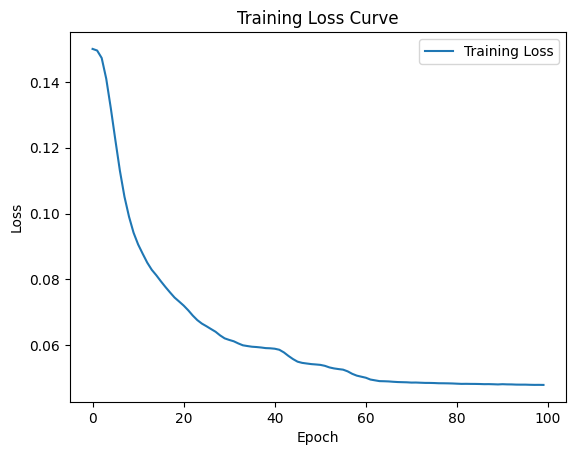

In [17]:
model_unfolded = UnfoldedNN(configs_unfolded).to(configs_unfolded["device"])
optimizer = Adam(model_unfolded.parameters(), lr=configs_unfolded["lr"])
L1 = nn.L1Loss()
print(model_unfolded)
train(model=model_unfolded, train_loader=train_loader, loss_fn=L1, optimizer=optimizer, configs=configs_unfolded)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model_unfolded)
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 334569


Test Loss: 0.0488
Average Sparsity: 0.7984


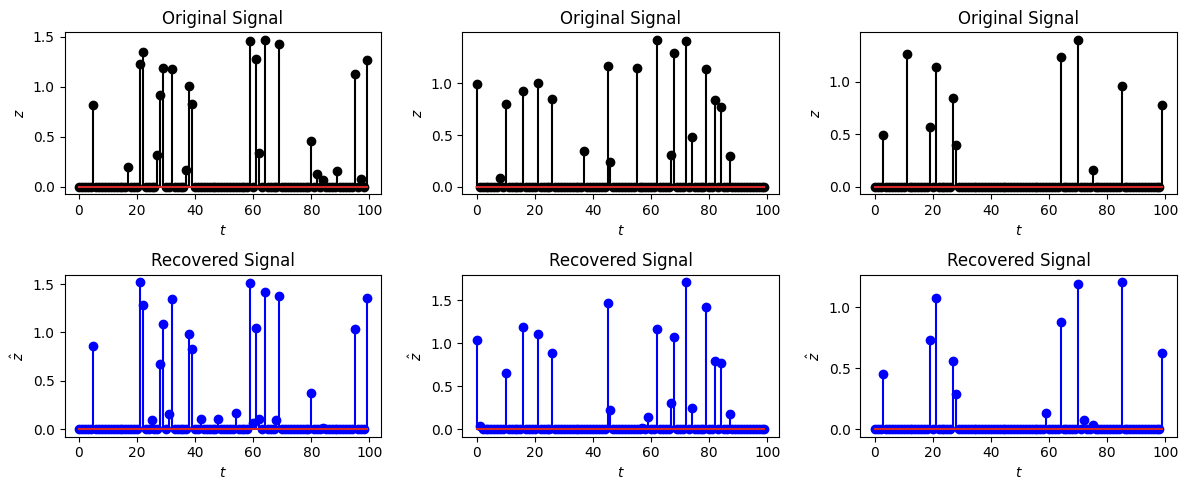

In [20]:
avg_eval_loss_unfolded, avg_eval_sparsity_unfolded = evaluate(model_unfolded, test_loader, L1, configs_unfolded)
_ = visualize(model_unfolded, test_loader, 3, configs_unfolded)

### Task 3.4

Add in your solution to Task 3.4 from the manual in the cells below.

In [21]:
# Computing Sparsity of Sparse_Signals.pkl
def compute_sparsity(signal, tol=1e-6):
    """
    Compute the sparsity of a given signal.
    signal: the input signal (could be z or z_hat)
    tol: threshold below which values are considered zero (to handle small floating-point values).
    
    Returns:
    sparsity: percentage of zero elements.
    """
    num_zeros = torch.sum(torch.abs(signal) < tol).item()  # Count number of "zero" elements
    sparsity = num_zeros / signal.numel()  # Calculate sparsity as the fraction of zeros
    return sparsity

def compute_average_sparsity(dataset, tol=1e-6):
    """
    Compute the average sparsity for a dataset of signals.
    dataset: SparseSignalsDataset object.
    tol: threshold below which values are considered zero.
    
    Returns:
    avg_sparsity: Average sparsity across all signals in the dataset.
    """
    sparsities = []
    
    for i in range(len(dataset)):
        z, _ = dataset[i]  # Get the z signal from the dataset (we ignore x here)
        sparsity = compute_sparsity(z, tol)
        sparsities.append(sparsity)
    
    avg_sparsity = np.mean(sparsities)  # Calculate the average sparsity across all signals
    return avg_sparsity

avg_sparsity = compute_average_sparsity(dataset, tol=1e-6)
print(f"Average sparsity of the dataset: {avg_sparsity:.4f}")

Average sparsity of the dataset: 0.7999


4. Compare the convergence of ISTA and LISTA for a given sparsity level of underlying vector z. For fair
comparison, you may want to match the sparsity levels in both cases. Please note that for ISTA, you can
directly control the sparsity levels during generation of z.

#### Answered in report
